# Strats vs Teles
Today I watched the first lecture of the fanstatic [fast.ai course](https://course.fast.ai/) where Jeremy encourages everyone to go out and create an image classifier for a real-world task.
Inspired by the guitar gathering dust in the corner of my room, I decided to create a classifier that can distinguish between the two most famous types of Fender electric guitars: The Telecaster and the Stratocaster.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

## Getting the data

`data/guitars` is the folder where I'm going to store the image files

In [3]:
path = Path('data/guitars')

and I'm only interested in two types of guitars:

In [4]:
classes = ['strat','tele']

I actually peaked a little in the notebook of the second lesson, where it is shown, how to get a bunch of image URLs from Google Images. The csv files with the URLs are stored in `/data/guitars/urls_strat.csv` and `/data/guitars/urls_tele.csv`.
So fist, let's download the images:

In [5]:
do_download = False

if do_download:
    for c in classes:
        download_images(path/f'urls_{c}.csv', path/f'{c}')
        verify_images(path/c, delete=True)

## Create the data set:

In [6]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
       ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [7]:
data.classes

['strat', 'tele']

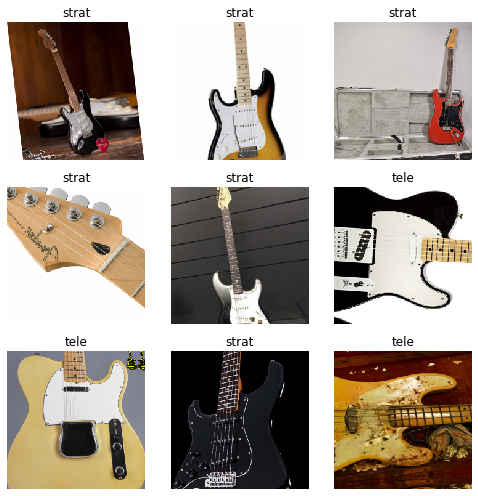

In [14]:
data.show_batch(rows=3, figsize=(7,7))

Please note the last picture ... that's clearly a bass guitar. So we probably will have to do some cleaning up of the data later

In [15]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['strat', 'tele'], 2, 868, 217)

In [16]:
bs = 64

## Creating a first model

Let's follow the lecture's advice and use resnet34 as basis for the classifier:

In [17]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [18]:
learn.fit_one_cycle(12)

epoch,train_loss,valid_loss,error_rate,time
0,1.097099,0.772041,0.359447,00:19
1,0.835390,0.475224,0.165899,00:21
2,0.678486,0.377193,0.142857,00:21
3,0.598437,0.411380,0.147465,00:19
4,0.531867,0.338639,0.096774,00:20
5,0.479682,0.334330,0.115207,00:19
6,0.433064,0.275810,0.087558,00:20
7,0.392560,0.300079,0.101382,00:18
8,0.354270,0.284408,0.082949,00:18
9,0.316231,0.293480,0.115207,00:21


Wow, 10% error rate?! From only a few hundred training examples? With training only a few minutes ... this is fantastic.

Now let's follow the first lecture to find out, what could be improved.

## Analyzing the model

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

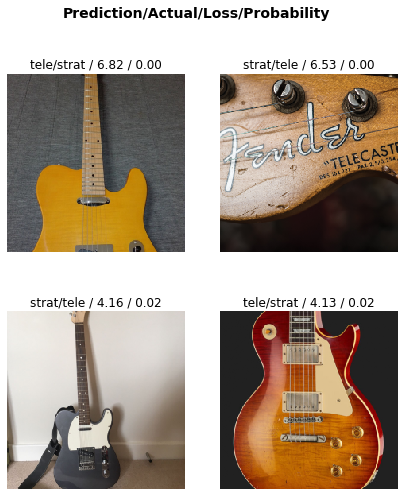

In [21]:
interp.plot_top_losses(4, figsize=(7,8))

Ok, this is interesting!
The first example clearly is has a wrong label: the network correctly classifies it as a tele, but the label is strat.
The other two examples are actual errors, but how did the Les Paul get into our dataset?!

In [22]:
interp.most_confused(min_val=2)

[('tele', 'strat', 15), ('strat', 'tele', 8)]

## Storing the first version of the model

In [23]:
learn.save('stage-1')

## Using the learning rate finder

In [76]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


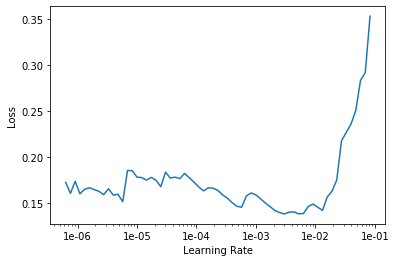

In [44]:
learn.recorder.plot()

Now we can train the *complete* model using different learning rates at different levels

In [77]:
learn.unfreeze()

In [78]:
learn.fit_one_cycle(12, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.192109,0.316927,0.115207,00:20
1,0.236750,0.242115,0.087558,00:22
2,0.257234,0.441471,0.138249,00:22
3,0.258626,0.535136,0.073733,00:20
4,0.234956,0.513508,0.110599,00:22
5,0.219606,0.352258,0.087558,00:22
6,0.188497,0.291164,0.073733,00:20
7,0.160840,0.252051,0.069124,00:19
8,0.135363,0.262538,0.046083,00:20
9,0.115657,0.232988,0.041475,00:20


In [79]:
learn.save('stage-2')

In [80]:
interp = ClassificationInterpretation.from_learner(learn)

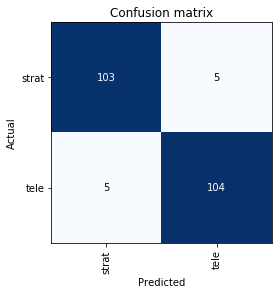

In [81]:
interp.plot_confusion_matrix()

In [8]:
from fastai.widgets import *

In [111]:
#  db = (ImageList.from_folder(path)
#                    .split_none()
#                    .label_from_folder()
#                    .transform(get_transforms(), size=224)
#                    .databunch()
#      )

In [84]:
# learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

In [85]:
# learn_cln.load('stage-2');

In [86]:
# ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [ ]:
# ImageCleaner(ds, idxs, path)

In [115]:
# !mv data/guitars/cleaned.csv data/guitars/cleaned_toploss.csv 

In [11]:
# db = (ImageList.from_csv(path, 'cleaned_toploss.csv', folder='.')
#                     .split_none()
#                     .label_from_df()
#                     .transform(get_transforms(), size=224)
#                     .databunch()
#       )

In [12]:
# learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

# learn_cln.load('stage-2');

In [13]:
# ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [15]:
# Path(ds.x.items[0]).is_file()

True

In [16]:
# ImageCleaner(ds, idxs, path=path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [18]:
#!mv data/guitars/cleaned.csv data/guitars/cleaned_toploss_and_top.csv

In [33]:
#  db = (ImageList.from_csv(path, 'cleaned_toploss_and_top.csv', folder='.')                     
#                      .label_from_df()
#                       .split()
#                      .transform(get_transforms(), size=224)
#                      .databunch()
#                        .normalize(imagenet_stats)
#        )
data = ImageDataBunch.from_csv(path,csv_labels='cleaned_toploss_and_top.csv', valid_pct=0.2,
       ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [34]:
data

ImageDataBunch;

Train: LabelList (785 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
tele,tele,tele,tele,tele
Path: data/guitars;

Valid: LabelList (196 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
tele,tele,strat,strat,strat
Path: data/guitars;

Test: None

In [35]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [36]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


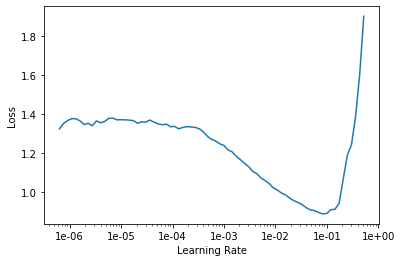

In [37]:
learn.recorder.plot()

In [38]:
learn.unfreeze()

In [39]:
learn.fit_one_cycle(12, max_lr=slice(1e-6,1e-1))

epoch,train_loss,valid_loss,error_rate,time
0,0.946620,0.676119,0.153061,00:17
1,0.734431,0.875563,0.112245,00:16
2,0.780920,0.574792,0.086735,00:16
3,0.782344,2.268040,0.198980,00:18
4,0.713068,1.182298,0.096939,00:18
5,0.738253,0.395483,0.076531,00:17
6,0.638875,0.172671,0.056122,00:18
7,0.523302,0.150491,0.035714,00:17
8,0.415473,0.109377,0.025510,00:16
9,0.333333,0.106307,0.030612,00:17


In [40]:
learn.save('stage-3')

In [41]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

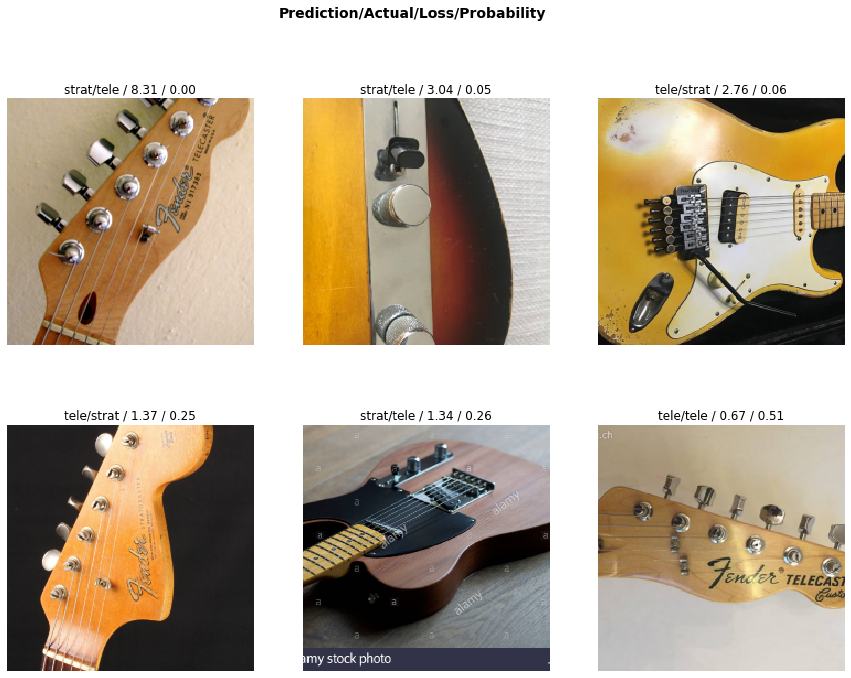

In [46]:
interp.plot_top_losses(6, figsize=(15,11))